In [1]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt


In [2]:
def clipped_poisson(lam, max_k):
    """
    Return poisson PMF clipped at max_k with remaining tail probability
    placed at max_k.
    """
    pmf = np.zeros(max_k + 1)
    for k in range(max_k):
        pmf[k] = math.exp(-lam) * lam**k / math.factorial(k)
    pmf[max_k] = 1 - np.sum(pmf)
    
    return pmf     


In [3]:
def build_rent_return_pmf(lambda_request, lambda_return, max_cars):
    """
    Return p(new_rentals, returns | initial_cars) as numpy array:
        p[initial_cars, new_rentals, returns]
    """
    pmf = np.zeros((max_cars+1, max_cars+1, max_cars+1))
    
    for init_cars in range(max_cars + 1):
        new_rentals_pmf = clipped_poisson(lambda_request, init_cars)
        for new_rentals in range(init_cars + 1):
            max_returns = max_cars - init_cars + new_rentals
            returns_pmf = clipped_poisson(lambda_return, max_returns)
            for returns in range(max_returns + 1):
                p = returns_pmf[returns] * new_rentals_pmf[new_rentals]
                pmf[init_cars, new_rentals, returns] = p
                
    return pmf

In [4]:
class JacksWorld(object):
    """Environment model of Jack's Car Rental"""
    def __init__(self, lambda_return1, lambda_return2,
                 lambda_request1, lambda_request2, max_cars):
        # pre-build the rentals/returns pmf for each location
        self.rent_return_pmf = []
        self.rent_return_pmf.append(build_rent_return_pmf(lambda_request1,
                                                      lambda_return1,
                                                      max_cars))
        self.rent_return_pmf.append(build_rent_return_pmf(lambda_request2,
                                                      lambda_return2,
                                                      max_cars))
        self.max_cars = max_cars
        
    def get_transition_model(self, s, a):
        """
        Return 2-tuple:
            1. p(s'| s, a) as dictionary:
                keys = s'
                values = p(s' | s, a)
            2. E(r | s, a, s') as dictionary:
                keys = s'
                values = E(r | s, a, s')
        """
        s = (s[0] - a, s[1] + a)         # move a cars from loc1 to loc2
        move_reward = -math.fabs(a) * 2  # ($2) per car moved
        t_prob, expected_r = ([{}, {}], [{}, {}])
        for loc in range(2):
            morning_cars = s[loc]
            rent_return_pmf = self.rent_return_pmf[loc]
            for rents in range(morning_cars + 1):
                max_returns = self.max_cars - morning_cars + rents
                for returns in range(max_returns + 1):
                    p = rent_return_pmf[morning_cars, rents, returns]
                    if p < 1e-5:
                        continue
                    s_prime = morning_cars - rents + returns
                    r = rents * 10
                    t_prob[loc][s_prime] = t_prob[loc].get(s_prime, 0) + p
                    expected_r[loc][s_prime] = expected_r[loc].get(s_prime, 0) + p * r
        
        # join probabilities and expectations from loc1 and loc2
        t_model, r_model = ({}, {})
        for s_prime1 in t_prob[0]:
            for s_prime2 in t_prob[1]:
                p1 = t_prob[0][s_prime1]  # p(s' | s, a) for loc1
                p2 = t_prob[1][s_prime2]  # p(s' | s, a) for loc2
                t_model[(s_prime1, s_prime2)] = p1 * p2
                # expectation of reward calculated using p(s', r | s, a)
                # need to normalize by p(s' | s, a)
                norm_E1 = expected_r[0][s_prime1] / p1
                norm_E2 = expected_r[1][s_prime2] / p2
                r_model[(s_prime1, s_prime2)] = norm_E1 + norm_E2 + move_reward
        return t_model, r_model

In [5]:
# Initialize environment

max_cars = 20
jacks = JacksWorld(lambda_return1=3, lambda_return2=5,
                 lambda_request1=4, lambda_request2=6, max_cars=max_cars)

# Initialize value function
V = np.zeros((max_cars+1, max_cars+1))
states = [(s0, s1) for s0 in range(max_cars+1) for s1 in range(max_cars+1)]
gamma = 0.9

start_time = time.time()
# Value Iteration
theta = 0.5          # V(s) delta stopping threshold
update_count = np.zeros((max_cars+1, max_cars+1)) # Count of updates for each state

print('Worst |V_old(s) - V(s)| delta:')
for k in range(100):
    delta = 0
    for s in states:
        v_old = V[s]
        v_best = -1000
        max_a = min(5, s[0], max_cars-s[1])
        min_a = max(-5, -s[1], -(max_cars-s[0]))
        for a in range(min_a, max_a+1):
            t_model, r_model = jacks.get_transition_model(s, a)            
            v_new = 0
            for s_prime in t_model:
                p = t_model[s_prime]
                r = r_model[s_prime]
                v_new += p * (gamma * V[s_prime] + r)
            v_best = max(v_best, v_new)
        V[s] = v_best
        delta = max(delta, abs(V[s] - v_old))
        
        # Asynchronous update count
        update_count[s] += 1
        
    print('Iteration {}: max delta = {:.2f}'.format(k, delta))
    if delta < theta: break

# Extract Policy from V(s)
pi = np.zeros((max_cars+1, max_cars+1), dtype=np.int16)
for s in states:
    best_v = -1000
    max_a = min(5, s[0], max_cars-s[1])
    min_a = max(-5, -s[1], -(max_cars-s[0]))
    for a in range(min_a, max_a+1):
        t_model, r_model = jacks.get_transition_model(s, a)
        v = 0
        for s_prime in t_model:
            p = t_model[s_prime]
            r = r_model[s_prime]
            v += p * (gamma * V[s_prime] + r)
        if v > best_v:
            pi[s] = a
            best_v = v
            
print('\nValue iteration done, final policy:')            
print(pi)           
print("\n--- {:.2f} seconds ---".format(time.time() - start_time))


Worst |V_old(s) - V(s)| delta:
Iteration 0: max delta = 344.40
Iteration 1: max delta = 194.93
Iteration 2: max delta = 122.23
Iteration 3: max delta = 96.32
Iteration 4: max delta = 75.58
Iteration 5: max delta = 61.23
Iteration 6: max delta = 50.35
Iteration 7: max delta = 41.38
Iteration 8: max delta = 33.91
Iteration 9: max delta = 27.74
Iteration 10: max delta = 22.67
Iteration 11: max delta = 18.51
Iteration 12: max delta = 15.12
Iteration 13: max delta = 12.34
Iteration 14: max delta = 10.07
Iteration 15: max delta = 8.22
Iteration 16: max delta = 6.71
Iteration 17: max delta = 5.48
Iteration 18: max delta = 4.47
Iteration 19: max delta = 3.65
Iteration 20: max delta = 2.98
Iteration 21: max delta = 2.43
Iteration 22: max delta = 1.98
Iteration 23: max delta = 1.62
Iteration 24: max delta = 1.32
Iteration 25: max delta = 1.08
Iteration 26: max delta = 0.88
Iteration 27: max delta = 0.72
Iteration 28: max delta = 0.59
Iteration 29: max delta = 0.48

Value iteration done, final po

In [6]:
print('Final state values:')
print(V)

Final state values:
[[683.76060719 693.74545615 703.70091085 713.55783556 723.20976522
  732.52542546 741.39521146 749.79587199 757.75647068 765.65782842
  773.45571603 780.89485744 788.30094544 795.28157141 802.15765287
  808.6864249  814.87348569 820.97986906 826.74969223 832.17565777
  837.25457187]
 [693.74178634 703.72672535 713.68338729 723.54339208 733.20001663
  742.5204403  751.39349969 759.79582016 767.69837747 775.49896874
  782.93621565 790.34226563 797.3227546  804.19204191 810.72061303
  816.90502854 823.00450069 828.77419582 834.20000156 839.42268472
  844.37060487]
 [703.60863774 713.59356274 723.55088156 733.41257756 743.07159182
  752.39385811 761.26694289 769.66727045 777.56546645 785.00034154
  792.40641039 799.38669093 806.24814197 812.77641484 818.96054887
  825.04793814 830.81742754 836.24299845 841.45231331 846.40003391
  850.99413057]
 [713.15123065 723.13578562 733.09252842 742.95304071 752.609798
  761.92811251 770.79486672 779.18614831 787.0715671  794.47773

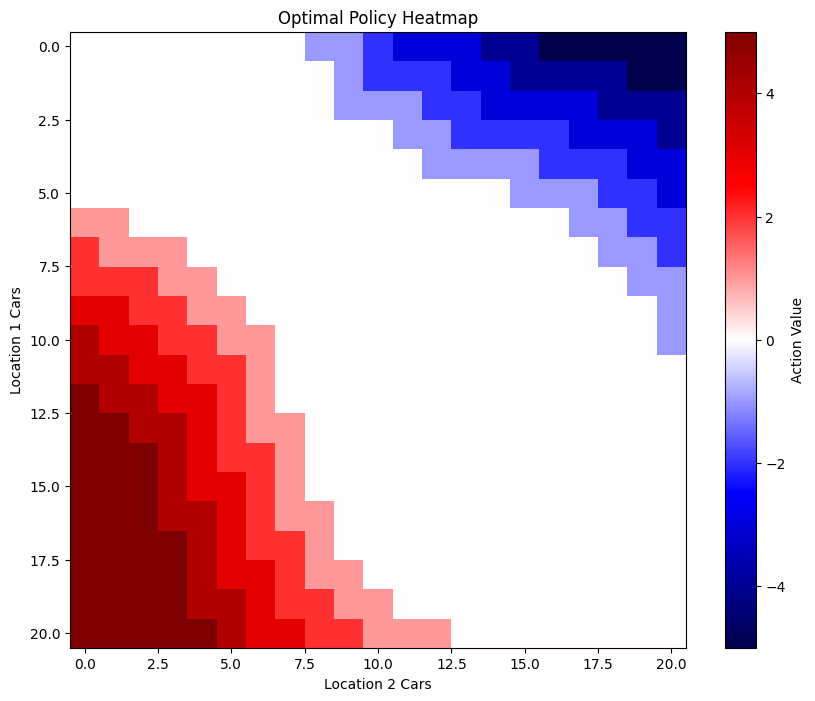

In [7]:
# Create the heatmap
heatmap = pi
plt.figure(figsize=(10, 8))
plt.imshow(heatmap, cmap='seismic', vmin=-5, vmax=5)
plt.colorbar(label='Action Value')
plt.xlabel('Location 2 Cars')
plt.ylabel('Location 1 Cars')
plt.title('Optimal Policy Heatmap')
plt.show()